# **BeReal - AB Test Analysis**

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, norm

## Load Dataset

In [2]:
# Define filepath
ab_test_filepath = '../datasets/ab_test_br.csv'

In [3]:
# Load dataset
df_ab_test_data = pd.read_csv(ab_test_filepath, sep=';')

In [4]:
# Explore ab_test_data shape
df_ab_test_data.head()

,keychain_udid,event_date,ab_test_cohort,ads_revenue,meaningful_reactions,sessions
0,secure_4A740435-89B3-4954-91F6-9B0415E25A52,09/11/2023,control,0.009652,3,12
1,secure_3FCDD36C-9708-4CC7-8DF0-B35EE8BA90F0,09/11/2023,test,0.033341,0,19
2,secure_6F665CEC-B52C-4404-9870-17A7EDFF5F7A,09/11/2023,test,0.082532,6,144
3,secure_72BFD723-8DDF-42D8-87E5-820FF0FE499A,09/11/2023,control,0.002670,5,26
4,secure_29E40A03-5C8F-4145-92AD-68E81426EEA1,10/11/2023,test,0.013517,3,53


## Prepare Analysis Dataset

In [5]:
# Get an overview of the dataset
df_ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124457 entries, 0 to 124456
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   keychain_udid         124444 non-null  object 
 1   event_date            124457 non-null  object 
 2   ab_test_cohort        124457 non-null  object 
 3   ads_revenue           124457 non-null  float64
 4   meaningful_reactions  124457 non-null  int64  
 5   sessions              124457 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 5.7+ MB


In [6]:
# Understand the distribution of values per column to catch outliers
df_ab_test_data.describe()

,ads_revenue,meaningful_reactions,sessions
count,124457.000000,124457.000000,124457.000000
mean,0.016887,0.849121,30.014166
std,0.048310,2.217483,53.855831
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.001254,0.000000,11.000000
75%,0.013271,1.000000,33.000000
max,2.204442,66.000000,2593.000000


In [7]:
# Check for missing values in all columns
missing_summary = df_ab_test_data.isnull().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = (missing_summary['missing_count'] / len(df_ab_test_data)) * 100
missing_summary = missing_summary.sort_values(by='missing_pct', ascending=False)
print(missing_summary)

                      missing_count  missing_pct
keychain_udid                    13     0.010445
event_date                        0     0.000000
ab_test_cohort                    0     0.000000
ads_revenue                       0     0.000000
meaningful_reactions              0     0.000000
sessions                          0     0.000000


In [8]:
# keychain_udid is our unique device identifier and is critical for any grouping, aggregation, or merging, 
# Records without it can't be reliably analyzed or joined with other datasets.
# We will drop rows with missing keychain_udid as they represent only 0.01% of the dataset (13 out of 124,457), so the impact is negligible
df_ab_test_data = df_ab_test_data[df_ab_test_data['keychain_udid'].notna()]

In [9]:
# Convert event_date to datetime format
df_ab_test_data['event_date'] = pd.to_datetime(df_ab_test_data['event_date'], format="%d/%m/%Y")

### Validate Cohorts are comparable

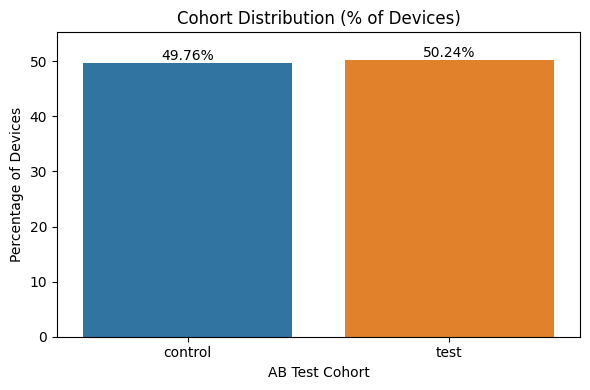

,Cohort,Devices,Percentage (%)
0,control,61921,49.76
1,test,62523,50.24


In [10]:
# Verify the dataset is correctly balanced between test and control (number of devices, event_date)
# Calculate total unique users and their percentages
cohort_counts = df_ab_test_data['ab_test_cohort'].value_counts().sort_index()
total = cohort_counts.sum()
cohort_pct = (cohort_counts / total * 100).round(2)

# Create DataFrame for plotting and display
cohort_summary = pd.DataFrame({
    'Cohort': cohort_counts.index,
    'Devices': cohort_counts.values,
    'Percentage (%)': cohort_pct.values
})

# Plot the bar chart
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=cohort_summary, x='Cohort', y='Percentage (%)', hue='Cohort')

# Add percentage labels on top of each bar
for index, row in cohort_summary.iterrows():
    ax.text(index, row['Percentage (%)'] + 0.5, f"{row['Percentage (%)']}%", ha='center', fontsize=10)

# Style and labels
plt.title('Cohort Distribution (% of Devices)')
plt.ylim(0, cohort_summary['Percentage (%)'].max() + 5)
plt.ylabel('Percentage of Devices')
plt.xlabel('AB Test Cohort')
plt.tight_layout()
plt.show()

# Show the summary table
cohort_summary

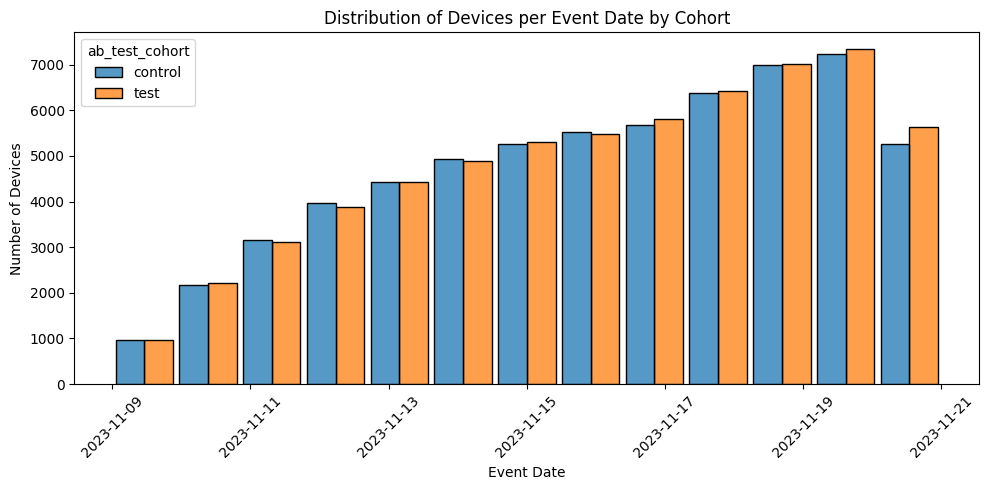

ab_test_cohort,control,test,total,%_control,%_test
event_date,,,,,
2023-11-09,963,956,1919,50.18,49.82
2023-11-10,2169,2224,4393,49.37,50.63
2023-11-11,3153,3115,6268,50.30,49.70
2023-11-12,3963,3888,7851,50.48,49.52
2023-11-13,4423,4430,8853,49.96,50.04
2023-11-14,4927,4886,9813,50.21,49.79
2023-11-15,5256,5302,10558,49.78,50.22
2023-11-16,5515,5481,10996,50.15,49.85
2023-11-17,5674,5816,11490,49.38,50.62


In [11]:
# Plot histogram showing device count distribution by event_date
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_ab_test_data,
    x='event_date',
    hue='ab_test_cohort',
    multiple='dodge',
    bins=len(df_ab_test_data['event_date'].unique()),  # one bin per date
    shrink=0.9,
)

plt.title('Distribution of Devices per Event Date by Cohort')
plt.xlabel('Event Date')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📋 Create the device count table
device_table = (
    df_ab_test_data
    .groupby(['event_date', 'ab_test_cohort'])['keychain_udid']
    .count()
    .reset_index(name='device_count')
    .pivot(index='event_date', columns='ab_test_cohort', values='device_count')
    .fillna(0)
    .astype(int)
)

# Add total and percentage columns
device_table['total'] = device_table.sum(axis=1)
device_table['%_control'] = (device_table['control'] / device_table['total'] * 100).round(2)
device_table['%_test'] = (device_table['test'] / device_table['total'] * 100).round(2)

# Display the full table
device_table

## Analysis

### Cohorts High-level Comparison

In [12]:
# Compare cohort level performance
df_ab_test_data.groupby('ab_test_cohort')[['sessions', 'meaningful_reactions', 'ads_revenue']].agg(['mean', 'median'])

sessions        meaningful_reactions        ads_revenue  \
                     mean median                 mean median        mean   
ab_test_cohort                                                             
control         29.711568   10.0             0.825617    0.0    0.017383   
test            30.319754   11.0             0.872575    0.0    0.016400   

                          
                  median  
ab_test_cohort            
control         0.001297  
test            0.001213

In [13]:
# Compare lift for each metric between cohorts
# Step 1: Calculate the mean for each cohort and metric
summary = (
    df_ab_test_data
    .groupby('ab_test_cohort')[['sessions', 'meaningful_reactions', 'ads_revenue']]
    .mean()
    .rename(index={'control': 'Control', 'test': 'Test'})
    .T
)

# Step 2: Calculate relative change (Delta %)
summary['Delta'] = (
    (summary['Test'] - summary['Control']) / summary['Control'] * 100
).round(2)

# Step 3: Format the delta as a string with +/– sign
summary['Delta'] = summary['Delta'].apply(lambda x: f"{x:+.2f}%")

# Step 4: Optional rounding of metrics
summary['Control'] = summary['Control'].round(5)
summary['Test'] = summary['Test'].round(5)

# Step 5: Reset index and rename for display
summary = summary.reset_index().rename(columns={'index': 'Metric'})

# Step 6: Clean up column order
summary = summary[['Metric', 'Control', 'Test', 'Delta']]

# Step 7: Display as a clean DataFrame
display(summary)

ab_test_cohort,Metric,Control,Test,Delta
0,sessions,29.71157,30.31975,+2.05%
1,meaningful_reactions,0.82562,0.87257,+5.69%
2,ads_revenue,0.01738,0.01640,-5.66%


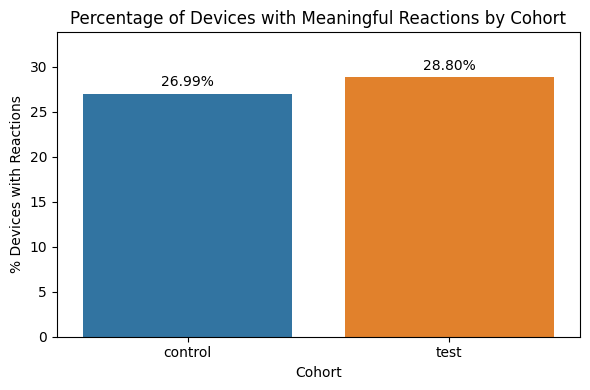

In [14]:
# Calculate % of users with meaningful reactions per cohort
reaction_summary = (
    df_ab_test_data
    .groupby('ab_test_cohort')['meaningful_reactions']
    .apply(lambda x: (x > 0).mean() * 100)
    .reset_index(name='pct_with_reactions')
)

# Plot bar chart
plt.figure(figsize=(6, 4))
barplot = sns.barplot(data=reaction_summary, x='ab_test_cohort', y='pct_with_reactions', hue='ab_test_cohort')

# Add percentage labels on top of each bar
for index, row in reaction_summary.iterrows():
    barplot.text(index, row['pct_with_reactions'] + 0.5, f"{row['pct_with_reactions']:.2f}%", 
                 ha='center', va='bottom', fontsize=10)

plt.title('Percentage of Devices with Meaningful Reactions by Cohort')
plt.ylabel('% Devices with Reactions')
plt.xlabel('Cohort')
plt.ylim(0, reaction_summary['pct_with_reactions'].max() + 5)  # add space for labels
plt.tight_layout()
plt.show()

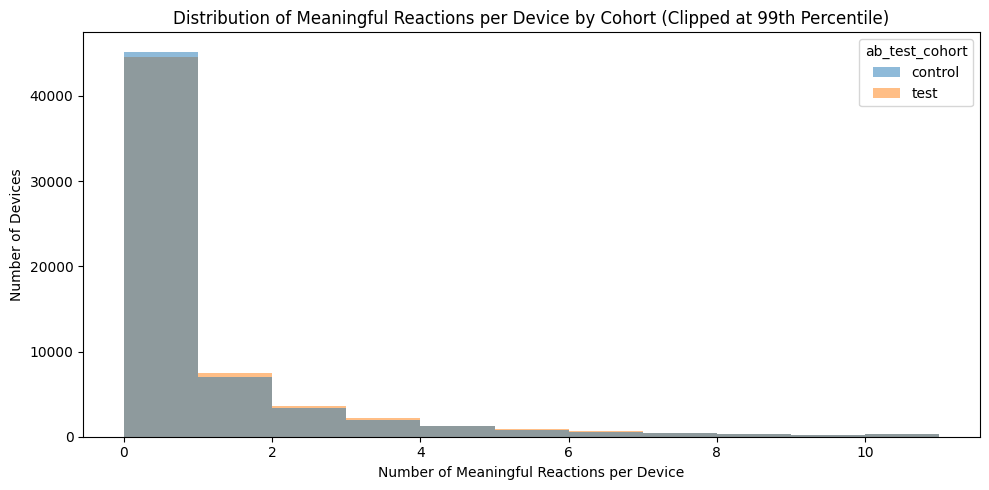

In [15]:
# Compare distribution of meaningful reactions per cohort
# Clip extreme values at 99th percentile
clip_threshold = df_ab_test_data['meaningful_reactions'].quantile(0.99)
data_clipped = df_ab_test_data[df_ab_test_data['meaningful_reactions'] <= clip_threshold]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(
    data=data_clipped,
    x='meaningful_reactions',
    hue='ab_test_cohort',
    multiple='layer',
    binwidth=1,
    edgecolor=None,
    linewidth=0
)

plt.title('Distribution of Meaningful Reactions per Device by Cohort (Clipped at 99th Percentile)')
plt.xlabel('Number of Meaningful Reactions per Device')
plt.ylabel('Number of Devices')
plt.tight_layout()
plt.show()

In [16]:
# Get a better perspective by improving the bins and display as a table
# Define bins for meaningful_reactions based on distribution
reaction_bins = [0, 1, 2, 3, 5, 10, 20, df_ab_test_data['meaningful_reactions'].max() + 1]
reaction_labels = ["0", "1", "2", "3-4", "5-9", "10-19", "20+"]

# Assign bins
df_ab_test_data['reaction_bin'] = pd.cut(
    df_ab_test_data['meaningful_reactions'],
    bins=reaction_bins,
    labels=reaction_labels,
    include_lowest=True,
    right=False
)

# Group and count devices
binned_counts = (
    df_ab_test_data
    .groupby(['reaction_bin', 'ab_test_cohort'])['keychain_udid']
    .count()
    .reset_index(name='device_count')
)

# Pivot to wide format
reaction_bin_table = (
    binned_counts
    .pivot(index='reaction_bin', columns='ab_test_cohort', values='device_count')
    .fillna(0)
    .astype(int)
    .reset_index()
)

# Compute % per group
reaction_bin_table['%_control'] = (
    reaction_bin_table['control'] / (reaction_bin_table['control'] + reaction_bin_table['test']) * 100
).fillna(0).round(2)

reaction_bin_table['%_test'] = (
    reaction_bin_table['test'] / (reaction_bin_table['control'] + reaction_bin_table['test']) * 100
).fillna(0).round(2)

# Display final table
final_table = reaction_bin_table[['reaction_bin', 'control', 'test', '%_control', '%_test']]
display(final_table)

ab_test_cohort,reaction_bin,control,test,%_control,%_test
0,0,45207,44515,50.39,49.61
1,1,7009,7512,48.27,51.73
2,2,3391,3651,48.15,51.85
3,3-4,3152,3465,47.63,52.37
4,5-9,2335,2524,48.06,51.94
5,10-19,730,763,48.89,51.11
6,20+,97,93,51.05,48.95


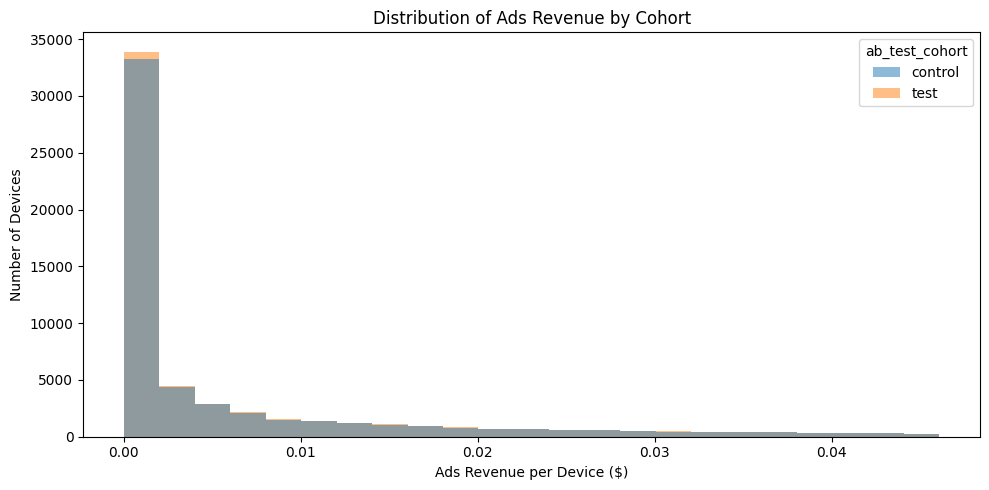

In [17]:
# Compare distribution of ads_revenue between the cohorts
# Clip extreme ads revenue values for readability
clip_max = df_ab_test_data['ads_revenue'].quantile(0.90)
data_clipped = df_ab_test_data[df_ab_test_data['ads_revenue'] <= clip_max]

# Plot overlapping histogram with strong colors
plt.figure(figsize=(10, 5))
sns.histplot(
    data=data_clipped,
    x='ads_revenue',
    hue='ab_test_cohort',
    multiple='layer',           # ✅ Allow overlap
    binwidth=0.002,
    edgecolor=None,             # Optional: remove edges for smoother look
    linewidth=0
)

plt.title('Distribution of Ads Revenue by Cohort')
plt.xlabel('Ads Revenue per Device ($)')
plt.ylabel('Number of Devices')
plt.tight_layout()
plt.show()

In [18]:
# Define focused revenue bins based on distribution, to better grasp the difference between groups for ads_revenue
revenue_bins = [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, df_ab_test_data['ads_revenue'].max()]
revenue_labels = [f"${revenue_bins[i]:.3f}–${revenue_bins[i+1]:.3f}" for i in range(len(revenue_bins)-1)]

# Bin the ads revenue values
df_ab_test_data['ads_revenue_bin'] = pd.cut(df_ab_test_data['ads_revenue'], bins=revenue_bins, labels=revenue_labels, include_lowest=True)

# Count devices per bin and cohort
revenue_binned_counts = (
    df_ab_test_data
    .groupby(['ads_revenue_bin', 'ab_test_cohort'])['keychain_udid']
    .count()
    .reset_index(name='device_count')
)

# Pivot to wide format
revenue_table = (
    revenue_binned_counts
    .pivot(index='ads_revenue_bin', columns='ab_test_cohort', values='device_count')
    .fillna(0)
    .astype(int)
    .reset_index()
)

# Compute cohort-wise percentages
revenue_table['%_control'] = (
    revenue_table['control'] / (revenue_table['control'] + revenue_table['test']) * 100
).fillna(0).round(2)

revenue_table['%_test'] = (
    revenue_table['test'] / (revenue_table['control'] + revenue_table['test']) * 100
).fillna(0).round(2)

# Final formatted table
final_revenue_table = revenue_table[['ads_revenue_bin', 'control', 'test', '%_control', '%_test']]

# Display
display(final_revenue_table)

ab_test_cohort,ads_revenue_bin,control,test,%_control,%_test
0,$0.000–$0.001,29703,30374,49.44,50.56
1,$0.001–$0.005,9462,9535,49.81,50.19
2,$0.005–$0.010,4953,5027,49.63,50.37
3,$0.010–$0.020,5369,5542,49.21,50.79
4,$0.020–$0.050,6542,6538,50.02,49.98
5,$0.050–$0.100,3447,3215,51.74,48.26
6,$0.100–$0.500,2353,2210,51.57,48.43
7,$0.500–$2.204,92,82,52.87,47.13


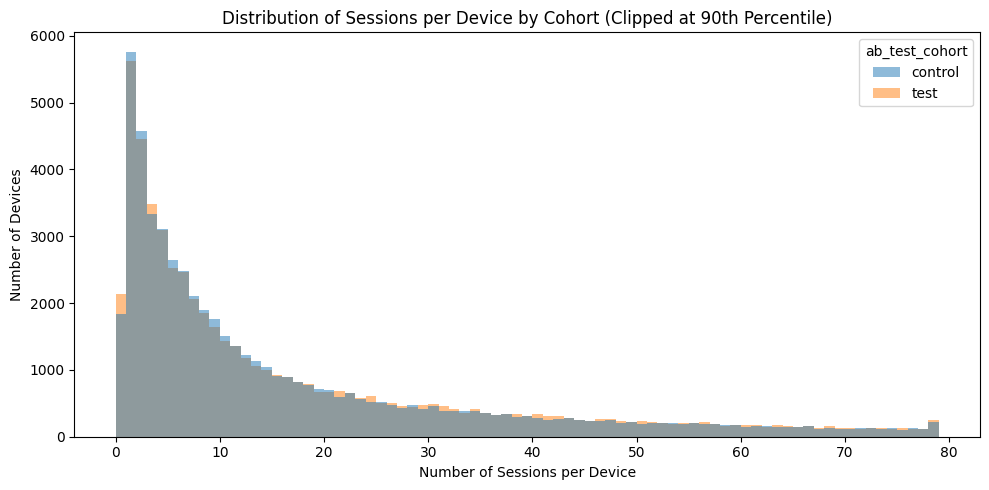

In [19]:
# Compare distribution of sessions between the cohorts
# Clip sessions at the 90th percentile for better readability
clip_threshold = df_ab_test_data['sessions'].quantile(0.90)
data_clipped_sessions = df_ab_test_data[df_ab_test_data['sessions'] <= clip_threshold]

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(
    data=data_clipped_sessions,
    x='sessions',
    hue='ab_test_cohort',
    multiple='layer',
    binwidth=1,
    edgecolor=None,
    linewidth=0
)

plt.title('Distribution of Sessions per Device by Cohort (Clipped at 90th Percentile)')
plt.xlabel('Number of Sessions per Device')
plt.ylabel('Number of Devices')
plt.tight_layout()
plt.show()

In [20]:
# Define focused session bins based on distribution, to better grasp the difference between groups
custom_bins = [0, 1, 3, 5, 10, 20, 50, 100, 500, df_ab_test_data['sessions'].max()]
labels = [f"{int(custom_bins[i])}–{int(custom_bins[i+1])}" for i in range(len(custom_bins)-1)]

# Create a binned column
df_ab_test_data['sessions_bin'] = pd.cut(df_ab_test_data['sessions'], bins=custom_bins, labels=labels, include_lowest=True)

# Count devices per bin and cohort
binned_counts = (
    df_ab_test_data
    .groupby(['sessions_bin', 'ab_test_cohort'])['keychain_udid']
    .count()
    .reset_index(name='device_count')
)

# Pivot table
session_bin_table = (
    binned_counts
    .pivot(index='sessions_bin', columns='ab_test_cohort', values='device_count')
    .fillna(0)
    .astype(int)
    .reset_index()
)

# Compute percentage per group
session_bin_table['%_control'] = (
    session_bin_table['control'] / (session_bin_table['control'] + session_bin_table['test']) * 100
).fillna(0).round(2)

session_bin_table['%_test'] = (
    session_bin_table['test'] / (session_bin_table['control'] + session_bin_table['test']) * 100
).fillna(0).round(2)

# Final table with clean structure
final_session_table = session_bin_table[['sessions_bin', 'control', 'test', '%_control', '%_test']]

# Display the final session distribution table
display(final_session_table)

ab_test_cohort,sessions_bin,control,test,%_control,%_test
0,0–1,7596,7766,49.45,50.55
1,1–3,7904,7931,49.91,50.09
2,3–5,5747,5614,50.59,49.41
3,5–10,9758,9474,50.74,49.26
4,10–20,9544,9338,50.55,49.45
5,20–50,10899,11639,48.36,51.64
6,50–100,6103,6370,48.93,51.07
7,100–500,4313,4323,49.94,50.06
8,500–2593,57,68,45.60,54.40


### T-test (Decision Metric) — Sessions per User

In [ ]:
# Run statistical analysis for decision metric (t-test)
# lift, effect_size, confidence intervals, p_value, expected_risk

In [21]:
# Prepare the groups
# Use sessions as the decision metric, best proxy for retention
test_group = df_ab_test_data[df_ab_test_data['ab_test_cohort'] == 'test']['sessions']
control_group = df_ab_test_data[df_ab_test_data['ab_test_cohort'] == 'control']['sessions']

# Descriptive stats
mean_test = test_group.mean()
mean_control = control_group.mean()
std_test = test_group.std()
std_control = control_group.std()
n_test = test_group.count()
n_control = control_group.count()

# T-test (Welch's, robust to unequal variances)
t_stat, p_value = ttest_ind(test_group, control_group, equal_var=False)

# Confidence Intervals (95%)
z = 1.96  # for 95% CI
se_test = std_test / np.sqrt(n_test)
se_control = std_control / np.sqrt(n_control)

ci_test = (mean_test - z * se_test, mean_test + z * se_test)
ci_control = (mean_control - z * se_control, mean_control + z * se_control)

# Effect size (absolute difference in means)
effect_size = mean_test - mean_control

# Lift (% improvement relative to control)
lift = (effect_size / mean_control) * 100

# Confidence (probability test > control)
pooled_se = np.sqrt((std_test**2 / n_test) + (std_control**2 / n_control))
z_score = effect_size / pooled_se
confidence = norm.cdf(z_score) * 100  # one-tailed

# Added impact (scaled to test group)
added_impact = effect_size * n_test

# Display results
print("🔍 A/B Test Results – Sessions")
print(f"Control Mean: {mean_control:.2f} | 95% CI: ({ci_control[0]:.2f}, {ci_control[1]:.2f})")
print(f"Test Mean:    {mean_test:.2f} | 95% CI: ({ci_test[0]:.2f}, {ci_test[1]:.2f})")
print(f"\n📊 t-statistic: {t_stat:.3f}")
print(f"p-value:      {p_value:.4f}")
print(f"Effect Size:  {effect_size:.2f}")
print(f"Lift:         {lift:.2f}%")
print(f"Confidence:   {confidence:.2f}%")
print(f"Added Impact (Sessions): {added_impact:.2f}")
print()
if p_value < 0.05:
    print("✅ Statistically significant difference in sessions between cohorts.")
else:
    print("❌ No statistically significant difference in sessions between cohorts.")

🔍 A/B Test Results – Sessions
Control Mean: 29.71 | 95% CI: (29.30, 30.13)
Test Mean:    30.32 | 95% CI: (29.89, 30.75)

📊 t-statistic: 1.992
p-value:      0.0464
Effect Size:  0.61
Lift:         2.05%
Confidence:   97.68%
Added Impact (Sessions): 38025.64

✅ Statistically significant difference in sessions between cohorts.


### T-test (Guardrail Metric) — Ads Revenue per User

In [22]:
# Evaluate whether we can confidently rollout despite the loss in ads_revenue
# Verify whether the difference in means is significant or not
# Prepare the groups
test_group = df_ab_test_data[df_ab_test_data['ab_test_cohort'] == 'test']['ads_revenue']
control_group = df_ab_test_data[df_ab_test_data['ab_test_cohort'] == 'control']['ads_revenue']

# Descriptive stats
mean_test = test_group.mean()
mean_control = control_group.mean()
std_test = test_group.std()
std_control = control_group.std()
n_test = test_group.count()
n_control = control_group.count()

# T-test (Welch's)
t_stat, p_value = ttest_ind(test_group, control_group, equal_var=False)

# Confidence Intervals (95%)
z = 1.96
se_test = std_test / np.sqrt(n_test)
se_control = std_control / np.sqrt(n_control)

ci_test = (mean_test - z * se_test, mean_test + z * se_test)
ci_control = (mean_control - z * se_control, mean_control + z * se_control)

# Effect size (difference in means)
effect_size = mean_test - mean_control

# Lift (% change)
lift = (effect_size / mean_control) * 100

# Confidence (probability test > control)
pooled_se = np.sqrt((std_test**2 / n_test) + (std_control**2 / n_control))
z_score = effect_size / pooled_se
confidence = norm.cdf(z_score) * 100

# Added impact
added_impact = effect_size * n_test

# Display results
print("🔍 A/B Test Results – Ads Revenue")
print(f"Control Mean: {mean_control:.5f} | 95% CI: ({ci_control[0]:.5f}, {ci_control[1]:.5f})")
print(f"Test Mean:    {mean_test:.5f} | 95% CI: ({ci_test[0]:.5f}, {ci_test[1]:.5f})")
print(f"\n📊 t-statistic: {t_stat:.3f}")
print(f"p-value:      {p_value:.4f}")
print(f"Effect Size:  {effect_size:.5f}")
print(f"Lift:         {lift:.2f}%")
print(f"Confidence:   {confidence:.2f}%")
print(f"Added Impact (Ads Revenue): {added_impact:.2f}")

if p_value < 0.05:
    print("✅ Statistically significant difference in ads revenue between cohorts.")
else:
    print("❌ No statistically significant difference in ads revenue between cohorts.")

🔍 A/B Test Results – Ads Revenue
Control Mean: 0.01738 | 95% CI: (0.01699, 0.01777)
Test Mean:    0.01640 | 95% CI: (0.01603, 0.01677)

📊 t-statistic: -3.589
p-value:      0.0003
Effect Size:  -0.00098
Lift:         -5.66%
Confidence:   0.02%
Added Impact (Ads Revenue): -61.47
✅ Statistically significant difference in ads revenue between cohorts.
